In [1]:
from Bio import PDB
import math
import os
import requests
import numpy as np

In [2]:
def load_codes(filepath):
    with open(filepath, "r", encoding="utf-8-sig") as f:
        codes = f.read().split()
    return codes

codes = load_codes("protein_codes.txt")
print(codes[:10])

['101M', '102L', '102M', '103L', '103M', '104L', '104M', '105M', '106M', '107L']


In [3]:
from Bio import PDB
import math

def get_ramachandran_coordinates(file_path):
    """
    Extracts only the phi (x) and psi (y) angles from a PDB file.
    Returns a dictionary with lists of x and y values.
    """
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('input_structure', file_path)
    
    ramachandran_data = {"x": [], "y": []}

    for model in structure:
        for chain in model:
            polypeptides = PDB.PPBuilder().build_peptides(chain)
            for poly in polypeptides:
                phi_psi = poly.get_phi_psi_list()
                
                for i, (phi, psi) in enumerate(phi_psi):
                    # Only append if both angles are present (not None)
                    if phi is not None and psi is not None:
                        # Convert radians to degrees
                        ramachandran_data["x"].append(math.degrees(phi))
                        ramachandran_data["y"].append(math.degrees(psi))
    ramachandran_data["x"] = np.array(ramachandran_data["x"])
    ramachandran_data["y"] = np.array(ramachandran_data["y"])
    coords = np.column_stack((ramachandran_data["x"], ramachandran_data["y"])) 
    return coords

In [7]:
get_ramachandran_coordinates(codes[1]+".pdb").shape

(161, 2)

In [8]:
def download_pdb_file(pdb_id, download_dir="."):
    """
    Downloads the .pdb file directly from RCSB using the PDB ID.
    """
    pdb_id = pdb_id.upper()
    pdb_file = f"{pdb_id}.pdb"
    file_path = os.path.join(download_dir, pdb_file)
    
    # Check if file already exists to save time/bandwidth
    if os.path.exists(file_path):
        print(f"File {pdb_file} already exists. Using local copy.")
        return file_path

    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    
    try:
        print(f"Downloading {pdb_id}...")
        response = requests.get(url)
        response.raise_for_status() # Raises error for 404 (ID not found)
        
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Download complete: {file_path}")
        return file_path
    except requests.exceptions.HTTPError:
        print(f"Error: PDB ID '{pdb_id}' not found on RCSB.")
        return None
    except Exception as e:
        print(f"Error downloading PDB: {e}")
        return None

def extract_sequence(file_path):
    """
    Extracts the amino acid sequence from the PDB file.
    Uses PPBuilder to ensure it matches the indices used in the Ramachandran calculation.
    """
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('seq_extraction', file_path)
    ppb = PDB.PPBuilder()
    
    full_sequence = ""
    
    for model in structure:
        for chain in model:
            # build_peptides filters out waters and heteroatoms automatically
            for pp in ppb.build_peptides(chain):
                full_sequence += str(pp.get_sequence())
                
    return full_sequence

# --- Main Pipeline ---

def process_pdb_pipeline(pdb_id):
    """
    Takes a PDB ID, downloads the file, calculates angles, and extracts sequence.
    """
    # 1. Download PDB
    file_path = download_pdb_file(pdb_id)
    if not file_path:
        return None

    # 2. Get Ramachandran Coordinates
    coords = get_ramachandran_coordinates(file_path)

    # 3. Extract Sequence
    sequence = extract_sequence(file_path)

    # 4. Package Results
    result = {
        "pdb_id": pdb_id,
        "sequence": sequence,
        "ramachandran": coords
    }
    
    return result


In [49]:
# -- Insert codes list into main Pipeline --
all_results = {}

for pdb_id in codes[:50]:
    print(f"Processing {pdb_id}...")
    data = process_pdb_pipeline(pdb_id)

    if data:
        print(f"\n--- Results for {data['pdb_id']} ---")
        print(f"Sequence ({len(data['sequence'])} residues): {data['sequence']}")

Processing 101M...
File 101M.pdb already exists. Using local copy.

--- Results for 101M ---
Sequence (154 residues): MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
Processing 102L...
File 102L.pdb already exists. Using local copy.

--- Results for 102L ---
Sequence (163 residues): MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK
Processing 102M...
File 102M.pdb already exists. Using local copy.

--- Results for 102M ---
Sequence (154 residues): MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
Processing 103L...
File 103L.pdb already exists. Using local copy.

--- Results for 103L ---
Sequence (159 residues): MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTSLDAAKSELDKAIGRNTNGV

In [11]:
protein_dict = {}
protein_dict[data['pdb_id']] = (data['sequence'], data['ramachandran'])

In [50]:
coords = get_ramachandran_coordinates(codes[0]+".pdb")
for i in range(1,50):
    coords = np.vstack((coords, get_ramachandran_coordinates(codes[i]+".pdb")))


In [51]:
coords.shape

(17334, 2)

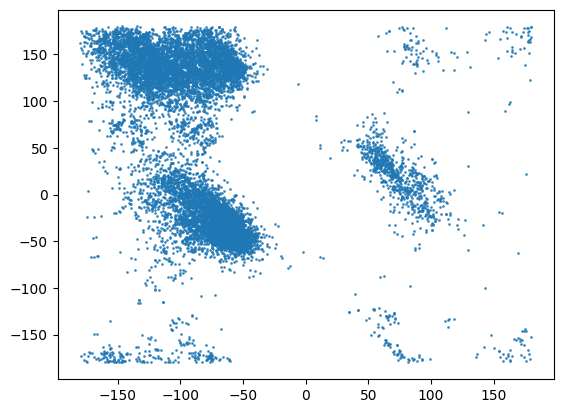

In [52]:
plt.scatter(x=coords[:,0], y=coords[:,1], alpha=0.75, s=1)

## Flow Matching

In [15]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [16]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [53]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(coords)
    x_0 = torch.randn_like(x_1) * 60
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

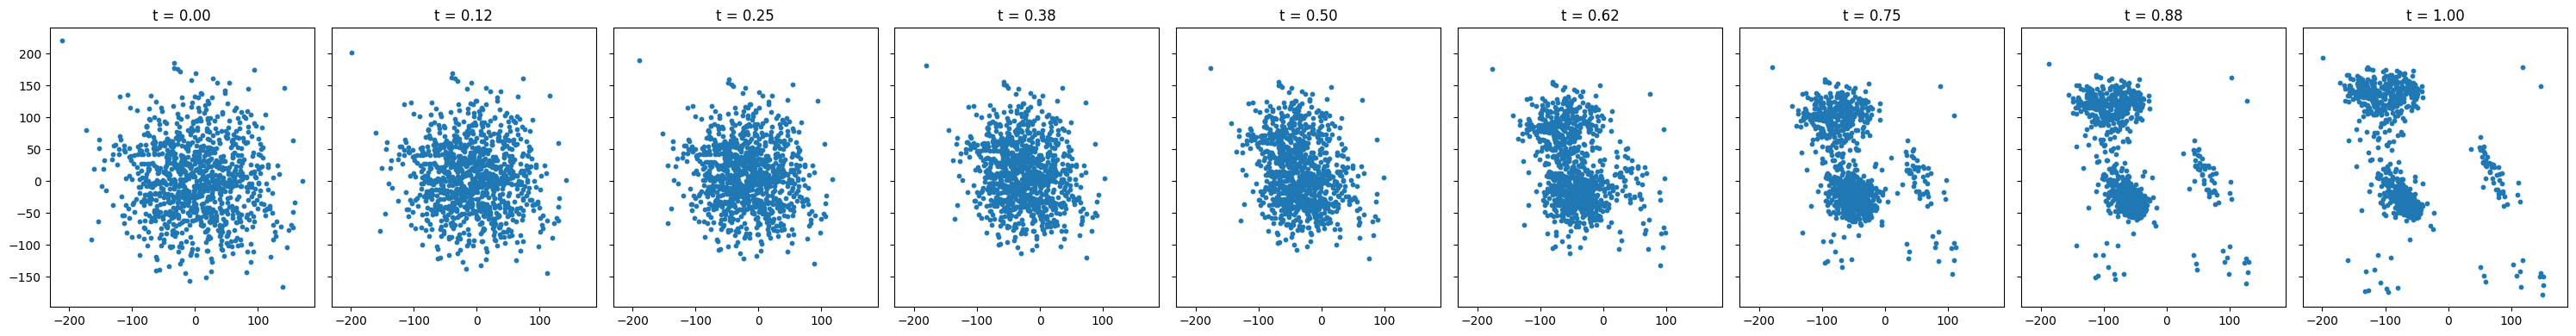

In [55]:
x = torch.randn(1000, 2) * 60
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
#axes[0].set_xlim(-3.0, 3.0)
#axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()